In [1]:
import gc
import os
import numpy as np
import pandas as pd

import time
import itertools
from tqdm import tqdm
from datetime import datetime
from scipy.stats import chi2_contingency

# import packages
from collections import defaultdict
import pandas.core.algorithms as algos
from pandas import Series
from scipy.stats import spearmanr
import re
import math
import traceback
import string

import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

gc.collect()

0

In [2]:
data = pd.read_csv('bank-additional-full.csv',sep=';')
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [3]:
predicting_feature = 'y'
categorical_features = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data.shape

(41188, 21)

In [4]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [5]:
data.nunique().sort_values()

y                    2
contact              2
default              3
housing              3
loan                 3
poutcome             3
marital              4
day_of_week          5
education            8
previous             8
emp.var.rate        10
month               10
nr.employed         11
job                 12
cons.price.idx      26
cons.conf.idx       26
pdays               27
campaign            42
age                 78
euribor3m          316
duration          1544
dtype: int64

In [6]:
for col in categorical_features:
    print(col)
    temp = pd.get_dummies(data[col],prefix=col)
    data = pd.concat([data.drop(columns=[col]),temp],axis=1)
data.shape

job
marital
education
default
housing
loan
contact
month
day_of_week
poutcome


(41188, 64)

In [8]:
data[predicting_feature] = (data[predicting_feature] == 'yes').astype(int)

In [10]:
data[predicting_feature].value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [11]:
data[predicting_feature].value_counts(normalize=True)

0    0.887346
1    0.112654
Name: y, dtype: float64

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=[predicting_feature]), data[predicting_feature],
                                                    stratify=data[predicting_feature], test_size=0.33, random_state=42)

In [14]:
X_train

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
7517,54,270,1,999,0,1.1,93.994,-36.4,4.864,5191.0,...,0,0,1,0,0,0,0,0,1,0
21591,40,172,1,999,0,1.4,93.444,-36.1,4.963,5228.1,...,0,0,0,0,0,1,0,0,1,0
13925,33,1060,2,999,0,1.4,93.918,-42.7,4.963,5228.1,...,0,0,1,0,0,0,0,0,1,0
33434,33,165,1,999,1,-1.8,92.893,-46.2,1.291,5099.1,...,0,0,0,0,0,1,0,1,0,0
6299,55,452,2,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28337,58,624,1,999,0,-1.8,93.075,-47.1,1.445,5099.1,...,0,0,0,0,0,0,1,0,1,0
7494,29,165,1,999,0,1.1,93.994,-36.4,4.864,5191.0,...,0,0,1,0,0,0,0,0,1,0
10747,35,544,3,999,0,1.4,94.465,-41.8,4.961,5228.1,...,0,0,0,0,0,1,0,0,1,0
34138,32,1805,4,999,0,-1.8,92.893,-46.2,1.281,5099.1,...,0,0,0,0,0,0,1,0,1,0


## Scaling and Variance Removal

In [15]:
X_train.shape

(27595, 63)

In [16]:
scaler_mm = MinMaxScaler()
X_train_scaled_mm = pd.DataFrame(scaler_mm.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
X_test_scaled_mm = pd.DataFrame(scaler_mm.fit_transform(X_test),columns=X_test.columns,index=X_test.index)

In [17]:
temp = X_train_scaled_mm.var().sort_values()
q1, q3 = np.percentile(temp.values,[25,75])
iqr = q3-q1
var_thresh = q1 - 1.5*iqr
var_thresh = max(var_thresh,0.001)
var_thresh

0.001

In [18]:
drop_variance = list(temp[temp <= var_thresh].index)
X_train.drop(columns=drop_variance,inplace=True,errors='ignore')
X_test.drop(columns=drop_variance,inplace=True,errors='ignore')
X_test = X_test[X_train.columns]

In [19]:
scaling_features = list(X_train.columns)
scaler_ss = StandardScaler()
X_train = pd.DataFrame(scaler_ss.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
X_test = pd.DataFrame(scaler_ss.fit_transform(X_test),columns=X_test.columns,index=X_test.index)

In [20]:
X_train.shape, X_test.shape

((27595, 61), (13593, 61))

# Removing Multicorrelation

In [21]:
def merge_common(lists): 
    neigh = defaultdict(set) 
    visited = set() 
    for each in lists: 
        for item in each: 
            neigh[item].update(each) 
    def comp(node, neigh = neigh, visited = visited, vis = visited.add): 
        nodes = set([node]) 
        next_node = nodes.pop 
        while nodes: 
            node = next_node() 
            vis(node) 
            nodes |= neigh[node] - visited 
            yield node 
    for node in neigh: 
        if node not in visited: 
            yield sorted(comp(node)) 

In [22]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [23]:
t = time.time()
final_iv, IV = data_vars(X_train,y_train)
t = time.time() - t
print(t/60)

C:\Users\Rishi\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.02884376049041748


In [24]:
t = time.time()
temp_corr = X_train.corr()
#temp_corr.to_csv('corr.csv')
t = time.time() - t
print(t/60)

0.0039231260617574055


In [25]:
%%time
correlated = []
temp = (temp_corr.abs().apply(lambda x : round(x,2)) >= 0.6).astype(int)
for col in temp.columns:
    temp2 = temp[col]
    indexes = [i for i in temp2[temp2 == 1].index]
    for ind in indexes:
        pair = set([col,ind])
        pair = list(pair)
        if ((pair not in correlated) & (len(pair) > 1)):
            correlated.append(pair)

clustered_variables = list(merge_common(correlated))
len(clustered_variables)

Wall time: 26.9 ms


8

In [26]:
IV = IV.sort_values(by=['IV'],ascending=False).reset_index(drop=True)
IV

,VAR_NAME,IV
0,duration,1.558933e+00
1,poutcome_success,5.097745e-01
2,euribor3m,3.391209e-01
3,nr.employed,3.215236e-01
4,poutcome_nonexistent,2.877198e-01
...,...,...
56,day_of_week_fri,1.794525e-05
57,loan_yes,1.626723e-05
58,education_professional.course,1.128624e-05
59,loan_no,3.345802e-07


In [27]:
zero_iv = list(IV[IV['IV'] == 0]['VAR_NAME'])
X_train.drop(columns=zero_iv,inplace=True,errors='ignore')
len(X_train.columns), X_train.columns

(60,
 Index(['age', 'duration', 'campaign', 'previous', 'emp.var.rate',
        'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
        'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
        'job_management', 'job_retired', 'job_self-employed', 'job_services',
        'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
        'marital_divorced', 'marital_married', 'marital_single',
        'marital_unknown', 'education_basic.4y', 'education_basic.6y',
        'education_basic.9y', 'education_high.school',
        'education_professional.course', 'education_university.degree',
        'education_unknown', 'default_no', 'default_unknown', 'housing_no',
        'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
        'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
        'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
        'month_nov', 'month_oct', 'month_sep', 'day_of_week

In [28]:
for clus in clustered_variables:
    df = pd.DataFrame(clus,columns=['VAR_NAME']).merge(IV,how='left').sort_values(by=['IV'],ascending=False)
    print(df['VAR_NAME'].iloc[0])
    drop_these = df['VAR_NAME'].iloc[1:]
    X_train.drop(columns=drop_these,inplace=True,errors='ignore')
gc.collect()

poutcome_success
euribor3m
marital_single
default_no
housing_no
housing_unknown
loan_yes
contact_cellular


45

In [29]:
print(len(X_train.columns))
X_train.columns

48


Index(['age', 'duration', 'campaign', 'cons.conf.idx', 'euribor3m',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_single', 'marital_unknown',
       'education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'housing_no', 'housing_unknown', 'loan_yes', 'contact_cellular',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_success'],
      dtype='object')

(-1.0, 1.0)

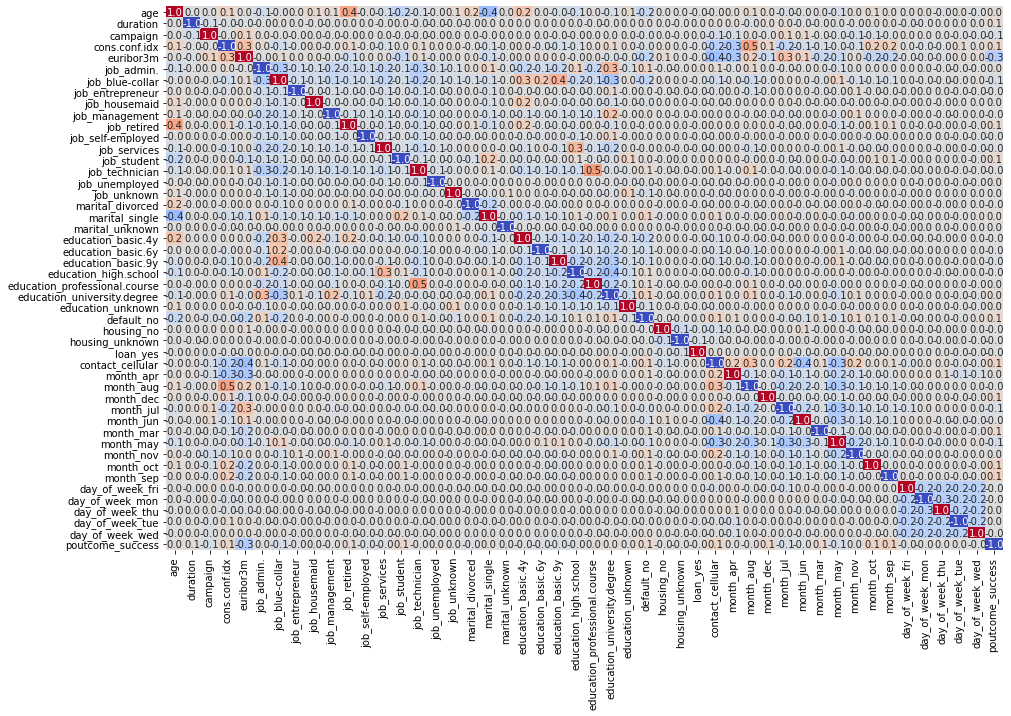

In [30]:
temp = X_train.corr()
temp = temp.apply(lambda x : np.round(x,2))
temp_cols = list(temp.columns)
for c in temp.columns:
    temp[c].loc[c] = (-1)**(temp_cols.index(c))
    
plt.figure(figsize=(15,10))
sns.heatmap(temp,annot=True,fmt='.1f',cbar=False,cmap='coolwarm')
gc.collect()
temp.min().min(), temp.max().max()

In [31]:
temp = X_train.corrwith(y_train.loc[X_train.index]).reset_index()
temp.columns = ['feature','correlation']
temp['abs_corr'] = temp['correlation'].abs()
temp.index = temp['feature']
temp = temp.sort_values(by=['abs_corr'],ascending=False).drop(columns=['feature'])
temp

,correlation,abs_corr
feature,,
duration,0.408052,0.408052
poutcome_success,0.312805,0.312805
euribor3m,-0.301064,0.301064
contact_cellular,0.142142,0.142142
month_mar,0.140357,0.140357
month_oct,0.136801,0.136801
month_sep,0.126986,0.126986
month_may,-0.105595,0.105595
default_no,0.098455,0.098455


# Model

In [32]:
X_train.columns

Index(['age', 'duration', 'campaign', 'cons.conf.idx', 'euribor3m',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_single', 'marital_unknown',
       'education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'housing_no', 'housing_unknown', 'loan_yes', 'contact_cellular',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_success'],
      dtype='object')

In [33]:
X_test = X_test[X_train.columns]
X_test

,age,duration,campaign,cons.conf.idx,euribor3m,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_success
37083,-1.335610,-0.127960,-0.210113,1.490549,-1.530589,1.723345,-0.541608,-0.195215,-0.164467,-0.272407,...,-0.709449,-0.33574,-0.128262,-0.115517,-0.475310,-0.508882,-0.518262,-0.500621,2.013246,-0.178997
37701,2.470618,-0.685170,0.147208,1.965812,-1.602810,-0.580267,-0.541608,-0.195215,-0.164467,-0.272407,...,-0.709449,-0.33574,-0.128262,-0.115517,-0.475310,-0.508882,-0.518262,-0.500621,2.013246,-0.178997
37370,0.948127,1.276673,-0.210113,1.965812,-1.586055,-0.580267,1.846352,-0.195215,-0.164467,-0.272407,...,-0.709449,-0.33574,-0.128262,-0.115517,-0.475310,-0.508882,-0.518262,1.997520,-0.496710,-0.178997
973,-0.288897,-0.723865,-0.567434,0.885669,0.709430,1.723345,-0.541608,-0.195215,-0.164467,-0.272407,...,1.409545,-0.33574,-0.128262,-0.115517,-0.475310,-0.508882,-0.518262,-0.500621,2.013246,-0.178997
15172,-1.335610,0.015212,1.219171,-0.475313,0.768363,1.723345,-0.541608,-0.195215,-0.164467,-0.272407,...,-0.709449,-0.33574,-0.128262,-0.115517,-0.475310,-0.508882,1.929526,-0.500621,-0.496710,-0.178997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9658,1.709373,0.224166,-0.567434,-0.280887,0.770096,-0.580267,-0.541608,-0.195215,-0.164467,-0.272407,...,-0.709449,-0.33574,-0.128262,-0.115517,-0.475310,1.965092,-0.518262,-0.500621,-0.496710,-0.178997
3656,0.091726,-0.336914,0.504529,0.885669,0.711163,-0.580267,-0.541608,-0.195215,-0.164467,3.670972,...,1.409545,-0.33574,-0.128262,-0.115517,2.103889,-0.508882,-0.518262,-0.500621,-0.496710,-0.178997
15698,-0.574364,-0.255654,-0.567434,-0.475313,0.769518,1.723345,-0.541608,-0.195215,-0.164467,-0.272407,...,-0.709449,-0.33574,-0.128262,-0.115517,-0.475310,1.965092,-0.518262,-0.500621,-0.496710,-0.178997
23162,1.328750,-0.155047,0.147208,0.950477,0.772407,1.723345,-0.541608,-0.195215,-0.164467,-0.272407,...,-0.709449,-0.33574,-0.128262,-0.115517,-0.475310,-0.508882,-0.518262,1.997520,-0.496710,-0.178997


In [34]:
X_train.shape, y_train.shape

((27595, 48), (27595,))

In [35]:
X_test.shape, y_test.shape

((13593, 48), (13593,))

In [36]:
y_train.value_counts(), y_test.value_counts(),

(0    24486
 1     3109
 Name: y, dtype: int64,
 0    12062
 1     1531
 Name: y, dtype: int64)

In [37]:
model = XGBClassifier(n_jobs=-1,random_state=42)
model.fit(X_train,y_train)

pred_test = model.predict_proba(X_test)
pred_test = [p[1] for p in pred_test]

pred_train = model.predict_proba(X_train)
pred_train = [p[1] for p in pred_train]

print(roc_auc_score(y_train,pred_train))
print(roc_auc_score(y_test,pred_test))

0.9879532713332335
0.9387874167660425


In [38]:
final_cols = list(X_train.columns)
np.array(final_cols)

array(['age', 'duration', 'campaign', 'cons.conf.idx', 'euribor3m',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_single', 'marital_unknown',
       'education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'housing_no', 'housing_unknown', 'loan_yes', 'contact_cellular',
       'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_success'],
      dtype='<U29')

In [41]:
def get_decile_data(y,pred,md,sr,ra,rl,ct,cl,cn,label,cuts=None):
    # Decile Chart
    temp = pd.DataFrame(y,columns=['actuals'])
    temp['predicted_probs'] = pred
    if cuts == None:

        temp = temp.reset_index()
        temp = temp.sort_values(by=['predicted_probs'],ascending=False)
        temp = temp.reset_index(drop=True).reset_index()
        temp['decile'] = ((temp['level_0']+1)*10/temp.shape[0]).apply(lambda x : math.ceil(x))
        temp = temp.sort_values(by=['index'],ascending=True)
        temp = temp.drop(columns=['index','level_0']).reset_index(drop=True)
        temp3 = temp.groupby(by=['decile']).agg({'actuals' : ['sum','count'], 'predicted_probs' : ['min','max']})
        temp3.columns = ['sum_actuals','count','min_prob','max_prob']
    else:
        vals = []
        for p in temp['predicted_probs']:
            vals.append((np.array(cuts) > p).sum())
        temp['decile'] = vals
        temp3 = temp.groupby(by=['decile']).agg({'actuals' : ['sum','count'], 'predicted_probs' : ['min','max']})
        temp3.columns = ['sum_actuals','count','min_prob','max_prob']
    
    temp3 = pd.DataFrame(list(range(1,11)),columns=['decile']).merge(temp3,on='decile',how='left').fillna(0)
    temp3['event_rate'] = temp3['sum_actuals']/temp3['count']
    temp3['event_rate_pct'] = [np.nan] + list(temp3['event_rate'].iloc[1:].values/(temp3['event_rate'].iloc[:-1].values + 0.001))
    temp3['random'] = temp3['sum_actuals'].sum()/temp3['count'].sum()
    #print(temp3.head())
    temp3['event_rate'] = temp3['event_rate'].apply(lambda x :np.round(x,2))
    temp3['random'] = temp3['random'].apply(lambda x : np.round(x,2))
    temp3['decile_lift'] = temp3['event_rate']/temp3['random']
    temp3['decile_lift'] = temp3['decile_lift'].apply(lambda x : np.round(x,2))
    temp3['cum_sum_actuals'] = temp3['sum_actuals'].cumsum()
    temp3['cum_count'] = temp3['count'].cumsum()
    temp3['cum_event_ratio'] = temp3['cum_sum_actuals']/temp3['cum_count']
    temp3['cum_event_ratio'] = temp3['cum_event_ratio'].apply(lambda x : np.round(x,2))
    temp3['lift_chart_lift'] = temp3['cum_event_ratio']/temp3['random']
    temp3['lift_chart_lift'] = temp3['lift_chart_lift'].apply(lambda x : np.round(x,2))
    temp3['lift_chart_ones'] = 1
    temp3['cum_event_rate'] = (temp3['sum_actuals']/temp3['sum_actuals'].sum()).cumsum().apply(lambda x : np.round(x,2))
    temp3['cum_event_rate'] = temp3['cum_event_rate']*100
    temp3['cum_perc_pop'] = np.arange(10,101,10)
    
    val = list(temp3['event_rate'])
    skr=1
    while ((val[skr-1] >= val[skr]) and (skr <= 8)):
        skr = skr + 1
    temp3['score9'] = skr
    temp3['data_type'] = label
    temp3['accuracy'] = accuracy_score(y,[np.round(i) for i in pred])
    temp3['precision'] = precision_score(y,[np.round(i) for i in pred])
    temp3['recall'] = recall_score(y,[np.round(i) for i in pred])
    temp3['f1'] = f1_score(y,[np.round(i) for i in pred])
    temp3['AUC'] = roc_auc_score(y,pred)
    
    temp3['max_depth'] = md
    temp3['subsample'] = sr
    temp3['alpha'] = ra
    temp3['lambda'] = rl
    temp3['colsample_bytree'] = ct
    temp3['colsample_bylevel'] = cl
    temp3['colsample_bynode'] = cn
    
    return temp3.reset_index(drop=True)

In [42]:
def bo_tune_xgb(max_depth, subsample, reg_alpha, reg_lambda, colsample_bylevel, colsample_bynode, colsample_bytree, eta, gamma, min_child_weight):
    params = {'max_depth': int(max_depth),
              'subsample': subsample,
              'reg_alpha' : int(reg_alpha),
              'reg_lambda' : int(reg_lambda),
              'colsample_bylevel' : colsample_bylevel,
              'colsample_bynode' : colsample_bynode,
              'colsample_bytree' : colsample_bytree,
              'eta' : eta,
              'gamma' : gamma,
              'min_child_weight' : min_child_weight,
              'eval_metric': 'auc',
              'n_jobs': -1,
              'random_state' : 42
             }
    
    model = XGBClassifier(**params)
    model.fit(X_train[final_cols],y_train)
    
    pred_test = model.predict_proba(X_test[final_cols])
    pred_test = [p[1] for p in pred_test]
    pred_train = model.predict_proba(X_train[final_cols])
    pred_train = [p[1] for p in pred_train]
    
    md = params['max_depth']
    sr = params['subsample']
    ra = params['reg_alpha']
    rl = params['reg_lambda']
    ct = params['colsample_bytree']
    cl = params['colsample_bylevel']
    cn = params['colsample_bynode']
    
    train = get_decile_data(list(y_train),pred_train,md,sr,ra,rl,ct,cl,cn,'train')
    decile_cuts = [1.01] + list(train['min_prob'])[:-1] + [0]
    test = get_decile_data(list(y_train),pred_train,md,sr,ra,rl,ct,cl,cn,'test',cuts=decile_cuts)
    
    auc_slope_score = ((train['score9'].iloc[0] * test['score9'].iloc[0])/81)*0.5
    auc_slope_score = auc_slope_score + (train['AUC'].iloc[0] * test['AUC'].iloc[0])*0.15
    
    s1 = sum((train['event_rate_pct'].dropna() - train['event_rate_pct'].dropna().mean())**2)
    s2 = sum((test['event_rate_pct'].dropna() - test['event_rate_pct'].dropna().mean())**2)
    auc_slope_score = auc_slope_score + (math.e**(-s1) * math.e**(-s2))*0.35
    
    
    #Return the negative RMSE
    return auc_slope_score

In [43]:
%%time

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth' : (1,30),
                                            'subsample' : (0,1),
                                            'reg_alpha' : (0,100),
                                            'reg_lambda' : (0,100),
                                            'colsample_bylevel' : (0,1),
                                            'colsample_bynode' : (0,1),
                                            'colsample_bytree' : (0,1),
                                            'eta' : (0,1),
                                            'gamma' : (0,100),
                                            'min_child_weight' : (0,100)
                                            })

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=25, init_points=25, acq='ei')

|   iter    |  target   | colsam... | colsam... | colsam... |    eta    |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------


<timed exec>:15: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument



| 1         | 0.6621    | 0.7628    | 0.3031    | 0.2723    | 0.3596    | 55.75     | 17.31     | 16.89     | 78.98     | 64.73     | 0.9799    |


C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


| 2         | 0.5657    | 0.5086    | 0.9345    | 0.08528   | 0.08446   | 19.68     | 28.97     | 47.14     | 8.672     | 22.95     | 0.1486    |
| 3         | 0.78      | 0.645     | 0.5751    | 0.2333    | 0.8518    | 18.3      | 8.514     | 7.553     | 31.13     | 84.74     | 0.6519    |
| 4         | 0.7324    | 0.4247    | 0.838     | 0.8646    | 0.7844    | 77.76     | 3.578     | 13.04     | 38.1      | 4.002     | 0.685     |
| 5         | 0.6305    | 0.8063    | 0.8235    | 0.01974   | 0.4084    | 48.4      | 12.36     | 51.63     | 27.63     | 34.05     | 0.5249    |
| 6         | 0.3057    | 0.8576    | 0.7154    | 0.5966    | 0.8307    | 62.02     | 8.032     | 28.95     | 81.09     | 0.4157    | 0.1289    |
| 7         | 0.6822    | 0.2984    | 0.982     | 0.06004   | 0.9308    | 84.92     | 6.278     | 12.6      | 64.94     | 98.45     | 0.8525    |


C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


| 8         | 0.4685    | 0.4796    | 0.2982    | 0.7848    | 0.02409   | 60.29     | 17.13     | 1.887     | 80.27     | 98.51     | 0.5261    |
| 9         | 0.4589    | 0.2151    | 0.7517    | 0.6456    | 0.7845    | 27.75     | 21.53     | 25.59     | 80.59     | 5.307     | 0.4511    |
| 10        | 0.7742    | 0.5921    | 0.1051    | 0.9406    | 0.2747    | 26.44     | 5.171     | 90.19     | 34.21     | 31.12     | 0.9554    |


C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


| 11        | 0.3439    | 0.4029    | 0.9462    | 0.2888    | 0.533     | 0.4376    | 9.577     | 55.68     | 24.71     | 54.75     | 0.0281    |
| 12        | 0.6432    | 0.6353    | 0.2196    | 0.7762    | 0.5633    | 21.48     | 11.57     | 18.57     | 29.43     | 96.97     | 0.5898    |
| 13        | 0.7775    | 0.2457    | 0.2599    | 0.4571    | 0.8468    | 5.812     | 6.348     | 53.4      | 3.574     | 84.14     | 0.1893    |


C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


| 14        | 0.4377    | 0.2073    | 0.0768    | 0.1138    | 0.01795   | 47.52     | 23.9      | 3.909     | 10.81     | 18.92     | 0.1298    |
| 15        | 0.475     | 0.8214    | 0.2629    | 0.008609  | 0.8259    | 54.8      | 26.34     | 16.92     | 49.02     | 11.16     | 0.6413    |
| 16        | 0.5122    | 0.3471    | 0.1293    | 0.6977    | 0.2065    | 90.18     | 12.34     | 85.73     | 91.12     | 6.41      | 0.6572    |


C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


| 17        | 0.4038    | 0.2495    | 0.3502    | 0.1058    | 0.839     | 62.43     | 14.49     | 71.18     | 91.7      | 29.23     | 0.009039  |


C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


| 18        | 0.4038    | 0.8214    | 0.07296   | 0.3209    | 0.3165    | 88.44     | 5.916     | 20.75     | 23.31     | 69.82     | 0.05352   |
| 19        | 0.5425    | 0.03952   | 0.01605   | 0.5974    | 0.7013    | 10.23     | 15.33     | 27.1      | 17.34     | 46.47     | 0.327     |


C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


| 20        | 0.4213    | 0.3935    | 0.2282    | 0.3276    | 0.1216    | 5.559     | 24.76     | 53.59     | 25.19     | 84.22     | 0.2767    |


C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


| 21        | 0.2948    | 0.6453    | 0.4533    | 0.004035  | 0.5994    | 98.87     | 20.53     | 70.43     | 54.03     | 80.21     | 0.2196    |
| 22        | 0.7004    | 0.7611    | 0.1817    | 0.8863    | 0.04422   | 40.23     | 19.97     | 39.49     | 61.53     | 55.31     | 0.5871    |
| 23        | 0.6045    | 0.6431    | 0.07371   | 0.9575    | 0.9708    | 11.2      | 22.23     | 25.12     | 39.94     | 49.03     | 0.6069    |
| 24        | 0.38      | 0.4531    | 0.1408    | 0.9099    | 0.3154    | 9.627     | 26.42     | 25.62     | 34.63     | 85.96     | 0.4276    |
| 25        | 0.8277    | 0.768     | 0.7013    | 0.8554    | 0.8884    | 11.17     | 18.87     | 18.86     | 8.121     | 73.61     | 0.7181    |
| 26        | 0.3511    | 0.996     | 0.3123    | 0.2306    | 0.5299    | 19.16     | 7.254     | 4.365     | 35.85     | 86.16     | 0.3265    |
| 27        | 0.5311    | 0.336     | 0.3414    | 0.3576    | 0.567     | 71.27     | 1.345     | 83.75     | 24.96     | 53

C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


| 36        | 0.4038    | 0.8853    | 0.4239    | 0.5018    | 0.2005    | 73.75     | 29.2      | 92.2      | 4.9       | 21.14     | 0.04463   |
| 37        | 0.8066    | 0.4433    | 0.6669    | 0.8848    | 0.1307    | 13.14     | 2.906     | 38.97     | 37.34     | 60.92     | 0.3811    |
| 38        | 0.2761    | 0.8772    | 0.1207    | 0.9912    | 0.8037    | 9.755     | 18.86     | 72.13     | 86.19     | 99.49     | 0.1562    |
| 39        | 0.3681    | 0.7819    | 0.4197    | 0.5694    | 0.5123    | 93.88     | 13.96     | 29.21     | 35.78     | 28.89     | 0.2904    |


C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rishi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


| 40        | 0.6215    | 0.2957    | 0.8849    | 0.7417    | 0.04588   | 30.58     | 25.49     | 73.16     | 50.87     | 10.41     | 0.1054    |
| 41        | 0.9042    | 0.6952    | 0.1742    | 0.396     | 0.2218    | 91.18     | 23.2      | 47.48     | 20.47     | 35.02     | 0.6853    |
| 42        | 0.836     | 0.2084    | 0.7145    | 0.5719    | 0.2388    | 31.34     | 24.22     | 14.45     | 66.4      | 82.82     | 0.6121    |
| 43        | 0.4295    | 0.8309    | 0.6522    | 0.5184    | 0.03623   | 91.16     | 18.76     | 87.04     | 41.46     | 48.65     | 0.4208    |
| 44        | 0.6891    | 0.8993    | 0.165     | 0.5789    | 0.1385    | 31.8      | 29.47     | 12.15     | 37.29     | 58.83     | 0.4087    |
| 45        | 0.6639    | 0.7238    | 0.6798    | 0.5728    | 0.6076    | 87.38     | 12.39     | 86.95     | 72.16     | 96.52     | 0.3783    |
| 46        | 0.4532    | 0.4865    | 0.0761    | 0.2685    | 0.6027    | 65.66     | 29.01     | 55.31     | 80.77     | 40

In [44]:
best_params = xgb_bo.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
print(best_params)

{'colsample_bylevel': 0.6951506527893864, 'colsample_bynode': 0.17417142954731513, 'colsample_bytree': 0.3960451059885225, 'eta': 0.22183018388441755, 'gamma': 91.18096308891397, 'max_depth': 23, 'min_child_weight': 47.47850078170565, 'reg_alpha': 20.46582395554456, 'reg_lambda': 35.017301689752976, 'subsample': 0.6852931816367424}


In [45]:
model = XGBClassifier(**best_params)
model.fit(X_train[final_cols],y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6951506527893864,
              colsample_bynode=0.17417142954731513,
              colsample_bytree=0.3960451059885225, early_stopping_rounds=None,
              enable_categorical=False, eta=0.22183018388441755,
              eval_metric=None, feature_types=None, gamma=91.18096308891397,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=23, max_leaves=None,
              min_child_weight=47.47850078170565, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [46]:
pred_test = model.predict_proba(X_test[final_cols])
pred_test = [p[1] for p in pred_test]
pred_train = model.predict_proba(X_train[final_cols])
pred_train = [p[1] for p in pred_train]

In [47]:
md = best_params['max_depth']
sr = best_params['subsample']
ra = best_params['reg_alpha']
rl = best_params['reg_lambda']
ct = best_params['colsample_bytree']
cl = best_params['colsample_bylevel']
cn = best_params['colsample_bynode']

In [48]:
train = get_decile_data(list(y_train),pred_train,md,sr,ra,rl,ct,cl,cn,'train')
decile_cuts = [1.01] + list(train['min_prob'])[:-1] + [0]
test = get_decile_data(list(y_test),pred_test,md,sr,ra,rl,ct,cl,cn,'test',cuts=decile_cuts)
result = pd.concat([train,test],axis=0).reset_index(drop=True)

In [54]:
result.columns

Index(['decile', 'sum_actuals', 'count', 'min_prob', 'max_prob', 'event_rate',
       'event_rate_pct', 'random', 'decile_lift', 'cum_sum_actuals',
       'cum_count', 'cum_event_ratio', 'lift_chart_lift', 'lift_chart_ones',
       'cum_event_rate', 'cum_perc_pop', 'score9', 'data_type', 'accuracy',
       'precision', 'recall', 'f1', 'AUC', 'max_depth', 'subsample', 'alpha',
       'lambda', 'colsample_bytree', 'colsample_bylevel', 'colsample_bynode'],
      dtype='object')

In [70]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=result[result['data_type'] == 'train']['cum_perc_pop'], y=result[result['data_type'] == 'train']['cum_event_rate'],
                         mode='lines+markers', name='With Model (Train)'))

fig.add_trace(go.Scatter(x=result[result['data_type'] == 'test']['cum_perc_pop'], y=result[result['data_type'] == 'test']['cum_event_rate'],
                         mode='lines+markers', name='With Model (Test)'))


fig.add_trace(go.Scatter(x=result[result['data_type'] == 'test']['cum_perc_pop'], y=result[result['data_type'] == 'test']['cum_perc_pop'],
                         mode='lines+markers', name='Random'))

#fig.add_trace(go.Bar(x=result[result['data_type'] == 'test']['decile'],y=result[result['data_type'] == 'test']['lift_chart_lift'],name='samples'))

fig.update_layout(title='1. Gain Chart',
                   xaxis_title='% of Customers',
                   yaxis_title='Cumulative % of Acceptance')
fig.show()
gc.collect()

237

In [71]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=result[result['data_type'] == 'train']['decile'], y=result[result['data_type'] == 'train']['event_rate'],
                         mode='lines+markers', name='With Model (Train)'))

fig.add_trace(go.Scatter(x=result[result['data_type'] == 'test']['decile'], y=result[result['data_type'] == 'test']['event_rate'],
                         mode='lines+markers', name='With Model (Test)'))

fig.add_trace(go.Scatter(x=result[result['data_type'] == 'test']['decile'], y=result[result['data_type'] == 'test']['random'],
                         mode='lines+markers', name='Random'))

#fig.add_trace(go.Bar(x=result[result['data_type'] == 'test']['decile'],y=result[result['data_type'] == 'test']['event_rate'],name='samples'))

fig.update_layout(title='2. Decile Chart - Acceptance Rate for each decile',
                   xaxis_title='Decile',
                   yaxis_title='Acceptance Rate')
fig.show()
gc.collect()

237

In [72]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=result[result['data_type'] == 'train']['cum_perc_pop'], y=result[result['data_type'] == 'train']['lift_chart_lift'],
                         mode='lines+markers', name='With Model (Train)'))

fig.add_trace(go.Scatter(x=result[result['data_type'] == 'test']['cum_perc_pop'], y=result[result['data_type'] == 'test']['lift_chart_lift'],
                         mode='lines+markers', name='With Model (Test)'))

fig.add_trace(go.Scatter(x=result[result['data_type'] == 'test']['cum_perc_pop'], y=result[result['data_type'] == 'test']['lift_chart_ones'],
                         mode='lines+markers', name='Random'))

fig.update_layout(title='3. Lift Chart - Acceptance with model vs Acceptance without model',
                   xaxis_title='% of Customers',
                   yaxis_title='Cumulative Lift')
fig.show()
gc.collect()

237

In [73]:
importance = pd.DataFrame(final_cols,columns=['feature'])
importance['importance'] = model.feature_importances_
importance = importance.sort_values(by=['importance'],ascending=False).reset_index(drop=True)
importance = importance[importance['importance'] > 0]
importance

,feature,importance
0,duration,0.294621
1,poutcome_success,0.229060
2,euribor3m,0.153074
3,contact_cellular,0.122946
4,month_oct,0.082215
5,month_may,0.065784
6,cons.conf.idx,0.012822
7,age,0.012010
8,marital_single,0.009905
9,job_blue-collar,0.008402


In [75]:
result.to_excel('result.xlsx',index=False)

In [86]:
df_decile_cuts = pd.DataFrame(range(1,11),columns=['decile'])
df_decile_cuts['min_prob'] = decile_cuts[1:]
df_decile_cuts['max_prob'] = [1] + decile_cuts[1:-1]
df_decile_cuts

,decile,min_prob,max_prob
0,1,0.277003,1.000000
1,2,0.185850,0.277003
2,3,0.096616,0.185850
3,4,0.067559,0.096616
4,5,0.050268,0.067559
5,6,0.042334,0.050268
6,7,0.039585,0.042334
7,8,0.038248,0.039585
8,9,0.033226,0.038248
9,10,0.000000,0.033226
